In [1]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

import casadi as ca
from scipy.integrate import solve_ivp

import modeller, fitter

reloadlibs = [modeller, fitter]
for lib in reloadlibs:
    reload(lib)

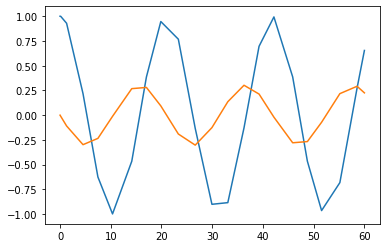

In [2]:
# pendulum system
# d2th/dt2 + g/l*sin(th) = 0

def system(t, y, p):
    return [
        y[1],
        -p[0]*np.sin(y[0])
    ]

p_true = [1/9.81]
# integrate forward
sol = solve_ivp(lambda t, y: system(t, y, p_true), [0, 60], [1, 0], dense_output=True)
plt.plot(sol.t, sol.y.T)

In [3]:
t_sample = np.linspace(0, 60, 15)
data_sample = sol.sol(t_sample).T
data_sample[7] = None

config = {
    "grid_size": 100,
    "basis_number": 50,
    "model_form": {
        "state": 2,
        "parameters": 1
    },
    "time_span": [0, 60],
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_sample, "t": t_sample},
    "observation_vector": [0, 1],
    "weightings":[
        [1]*1, # num params
        [1]*len(t_sample)
    ],
    "regularisation_value": [0],
}

In [4]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha])
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [5]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getdx = ca.Function('getdx', [solver_setup['x']], [model.xdash])
getc = ca.Function('getc', [solver_setup['x']], model.cs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
f_ex = ca.Function('f_ex', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])

In [6]:
p0 = [0]
c0 = np.ones(config['basis_number']*config['model_form']['state'])
x0 = np.hstack([*c0, p0])

In [7]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-5]))
    xguess = np.array(solutions[-1]['x']).flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      827

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2423307e-07 0.00e+00 1.09e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.2415892e-07 0.00e+00 5.15e-11  -8.6 1.98e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   4.2415892320856473e-07    4.2415892320856473e-07
Dual infeasibility......:   5.1520547381290124e-11    5.1520547381290124e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      827

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0340800e-06 0.00e+00 1.60e-05  -1.0 0.00e+00    -  0.00e+00 0.

Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   6.6081307092957786e-12    6.6081307092957786e-12


Number of objective function evaluations             = 326
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPOPT (w/o function evaluations)   =      0.009
Total CPU secs in NLP function evaluations           =      0.005

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.19ms ( 12.85us)   4.30ms ( 13.20us)       326
    nlp_grad  |  28.00us ( 28.00us)  28.06us ( 28.06us)         1
  nlp_grad_f  | 389.00us ( 25.93us) 387.22us ( 25.81us)        15
  nlp_hess_l  

True [0.1019367991845056] Recovered 0.101955


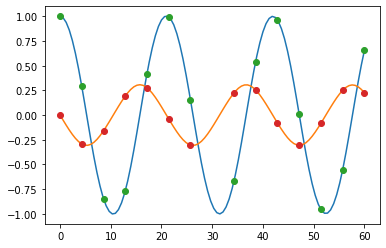

In [8]:
idx = 80
for y in getx(solutions[idx]['x']):
    plt.plot(model.observation_times, y)
plt.plot(t_sample, data_sample, 'o')
print("True", p_true, "Recovered", getp(solutions[idx]['x']))

In [9]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

Text(0, 0.5, 'Model Error')

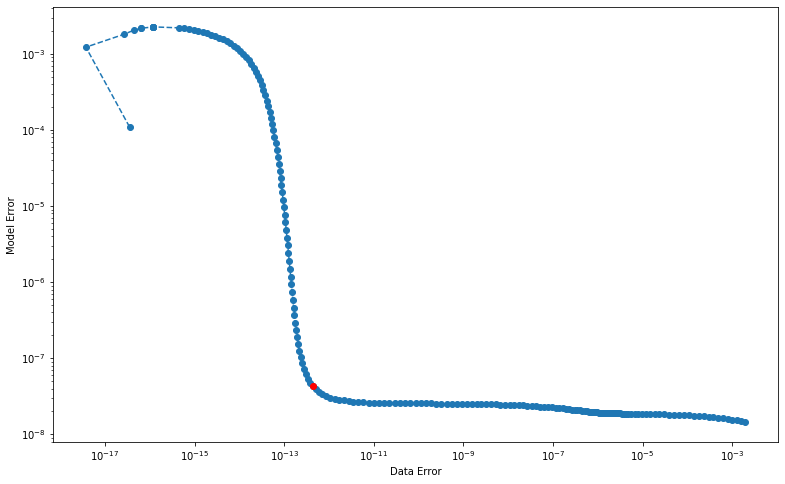

In [10]:
idx = 80
fig, ax=plt.subplots(figsize=[13, 8])
ax.loglog(*fsvals.T, 'o--')
ax.loglog(*fsvals[idx], 'ro')
ax.set_xlabel("Data Error")
ax.set_ylabel("Model Error")